In [3]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

seed = random.randint(1, 100)

In [4]:
drive.mount('/content/drive')

IMG_SIZE = 512

if IMG_SIZE == 256:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256'
elif IMG_SIZE == 512:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/512'

input_path = os.path.join(path,"image/")
mask_path = os.path.join(path,"mask/")

Mounted at /content/drive


In [5]:
def parse_image(image_path):
    mask_path = tf.strings.regex_replace(image_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "input_resize_patches", "mask_resize_patches")

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)

    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)

    return {'image' : image, 'segmentation_mask': mask}

In [6]:
train_dataset = tf.data.Dataset.list_files(input_path + "*.png")

train_size = 0.8 * train_dataset.cardinality().numpy()

validation_size = 0.1 * train_dataset.cardinality().numpy()

train_ds = train_dataset.take(train_size)

extra = train_dataset.skip(train_size)  

val_ds = extra.take(validation_size)

test_ds = extra.skip(validation_size)

train_dataset = train_dataset.map(parse_image)

train_ds = train_ds.map(parse_image)

test_ds = test_ds.map(parse_image)

val_ds = val_ds.map(parse_image)

In [7]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image, input_mask

def load_image_train(datapoint: dict) -> tuple:
    
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint: dict) -> tuple:

    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
BATCH_SIZE = 8

buffer_size = 1000

dataset = {"train": train_ds, "test": test_ds, "val": val_ds}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=buffer_size, seed=47)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].repeat()
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=AUTOTUNE)

In [9]:
def seg_unet(img_shape):
    inputs = Input(shape=img_shape)

    previous_block_activation = inputs

    contraction = {}
    for f in [32, 64, 128, 256]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    for f in reversed([32, 64, 128, 256]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(255, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = seg_unet((IMG_SIZE, IMG_SIZE, 3))

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [11]:
EPOCHS = 10

length_data = train_ds.cardinality().numpy()

length_val = val_ds.cardinality().numpy()

STEPS_PER_EPOCH = length_data // BATCH_SIZE
VALIDATION_STEPS = length_val // BATCH_SIZE

In [12]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

Epoch 1/10
120/120 [==============================] - 210s 603ms/step - loss: 0.6942 - accuracy: 0.8528 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
120/120 [==============================] - 72s 598ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 4.1478e-04 - val_accuracy: 1.0000
Epoch 3/10
120/120 [==============================] - 72s 599ms/step - loss: 5.3656e-04 - accuracy: 0.9998 - val_loss: 1.6309e-04 - val_accuracy: 1.0000
Epoch 4/10
120/120 [==============================] - 72s 598ms/step - loss: 2.4566e-04 - accuracy: 0.9999 - val_loss: 7.4614e-05 - val_accuracy: 1.0000
Epoch 5/10
120/120 [==============================] - 72s 598ms/step - loss: 1.2675e-04 - accuracy: 1.0000 - val_loss: 3.5015e-05 - val_accuracy: 1.0000
Epoch 6/10
120/120 [==============================] - 72s 598ms/step - loss: 4.9654e-05 - accuracy: 1.0000 - val_loss: 2.2306e-05 - val_accuracy: 1.0000
Epoch 7/10
120/120 [==============================] - 72s 597ms/step - loss: 2.2011e-05 - acc

In [13]:
model.save("/content/drive/MyDrive/"+"lr01_e10_bs8.h5")

In [14]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
loss_age = model_history.history['accuracy']
val_loss_age = model_history.history['val_accuracy']

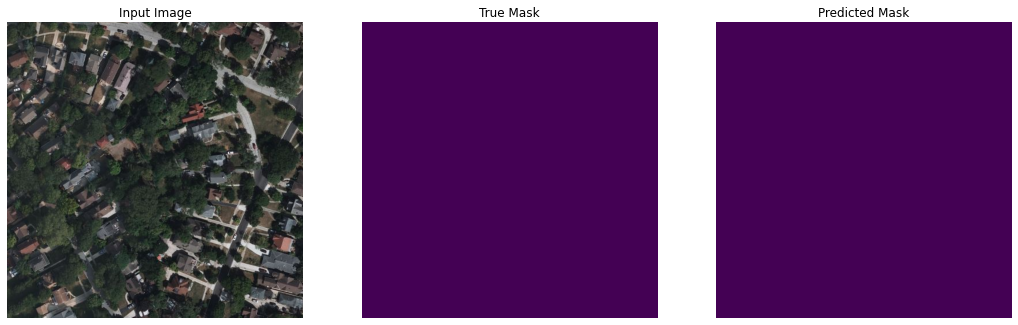

In [15]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

for image, mask in dataset['test'].take(1):
        pred_mask = model.predict(image)
        display_sample([image[0], mask[0], create_mask(pred_mask[0])])